In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import linalg as lin
from cs771 import plotData as pd, utils, genSyntheticData as gsd
from sklearn.svm import LinearSVC as csvm
import random
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

In [3]:
# Our usual checkerboard pattern of two rows of clusters of alternating labels
def genImbalancedStackedCirclesData( d, n, r, b ):
    tmp1 = gsd.genSphericalData( d, n//b, [0, -5], r )
    XPos = np.vstack( (tmp1) )
    yPos = np.ones( (XPos.shape[0],) )
    
    tmp1 = gsd.genSphericalData( d, n, [-8, 5], r )
    tmp2 = gsd.genSphericalData( d, n//b, [-8, -5], r )
    tmp3 = gsd.genSphericalData( d, n//b, [8, -5], r )
    tmp4 = gsd.genSphericalData( d, n, [8, 5], r )
    XNeg = np.vstack( (tmp1, tmp2, tmp3, tmp4) )
    yNeg = -np.ones( (XNeg.shape[0],) )
    
    return (XPos, yPos, XNeg, yNeg)

d = 2 
n = 100
b = 30
r = 3

(XPos, yPos, XNeg, yNeg) = genImbalancedStackedCirclesData( d, n, r, b )

Xtrn = np.vstack( (XPos, XNeg) )
ytrn = np.concatenate( (yPos, yNeg) )
randPerm = np.random.permutation( Xtrn.shape[0] )
Xtrn = Xtrn[randPerm,:]
ytrn = ytrn[randPerm]

c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


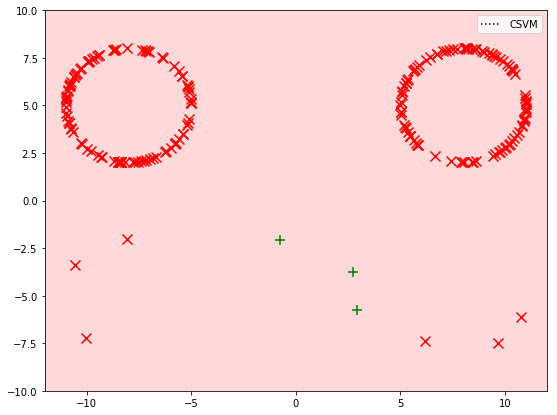

In [4]:
def linearCSVMClassifier( X ):
    return clf.predict( X )

clf = csvm( penalty= "l2", loss = "squared_hinge", C = 1.0, fit_intercept = True )
clf.fit( Xtrn, ytrn )

fig = pd.getFigure( 9, 7 )
pd.shade2D( linearCSVMClassifier, fig, mode = 'batch', xlim = 12, ylim = 10 )
pd.plot2D( XPos, fig, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig, color = 'r', marker = 'x' )
pd.plotLine( clf.coef_.T, clf.intercept_, fig, linestyle = ':', xlimL = -12, xlimR = 12, label = "CSVM" )

c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37

Using CPos = 1.959716 and CNeg = 0.040284
Using CPos = 1.911796 and CNeg = 0.088204
Using CPos = 1.890567 and CNeg = 0.109433
Using CPos = 1.920901 and CNeg = 0.079099
Using CPos = 1.904937 and CNeg = 0.095063
Using CPos = 1.922478 and CNeg = 0.077522
Using CPos = 1.918356 and CNeg = 0.081644
Using CPos = 1.864200 and CNeg = 0.135800
Using CPos = 1.920285 and CNeg = 0.079715


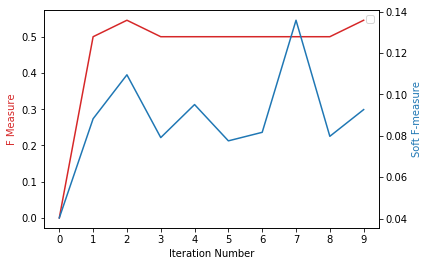

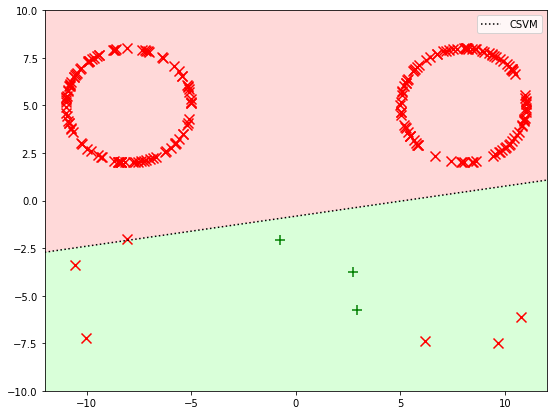

In [5]:
def TPR( yhat, y ):
    P = np.sum( 1 + y )/2
    return (1 + yhat).dot( 1 + y ) / (4 * P)

def TNR( yhat, y ):
    N = np.sum( 1 - y )/2
    return (1 - yhat).dot( 1 - y ) / (4 * N)

def skew( y ):
    return np.sum(1 - y)/np.sum( 1 + y )

def sigmoid( t ):
    return 1 / (1 + np.exp( -t ))

def FMeasure( clf, X, y ):
    yhat = clf.predict( X )
    P = TPR( yhat, y )
    N = TNR( yhat, y )
    t = skew( y )
    return (2 * P) / (1 + t + P - t * N)

def softFMeasure( clf, X, y ):
    # The reshape operation is there to convert a column vector into a numpy array
    s = (X.dot( clf.coef_.T ) + clf.intercept_).reshape( -1 )
    rewards = sigmoid( s * y )
    P = np.sum( rewards[y > 0] ) / np.sum( y > 0 )
    N = np.sum( rewards[y < 0] ) / np.sum( y < 0 )
    t = skew( y )
    return 2 * P / (1 + t + P - t * N)

# This is the AMP method taken from Narasimhan et al. ICML 2015
# Optimizing Non-decomposable Performance Measures: A Tale of Two Classes
def optimizeFMeasure( X, y, niter ):
    Xbiased = np.hstack( (X, np.ones( (X.shape[0], 1) )) )
    t = skew( y )
    perf = np.zeros( (niter,) )
    softPerf = np.zeros( (niter,) )
    
    clf = csvm( penalty= "l2", loss = "squared_hinge", C = 1.0, fit_intercept = True )
    clf.fit( Xtrn, ytrn )
    perf[0] = FMeasure( clf, X, y )
    # Sometimes it is better to use a "softer" notion of TPR and TNR based on
    # sigmoidal rewards instead of the usual count based definition
    softPerf[0] = softFMeasure( clf, X, y )
    
    for i in np.arange( 1, niter ):
        # We ensure that our notion of performance always gives a value between (0,1)
        # If perf is small (e.g. perf -> 0), CPos is large (-> 2) whereas CNeg is small (-> 0)
        # As perf improves (increases), CPos is decreased and CNeg is increased accordingly
        # When we have perfect classification (e.g. perf -> 1), we have CPos, CNeg both -> 1
        # This method autotunes the weights assigned to the positives and negatives
        CPos = 2 - softPerf[i-1]
        CNeg = softPerf[i-1]
        
        # The above is just a special case of a more general rule for optimizing such
        # imbalance-aware performance measures. See references for more details if interested.
        print( "Using CPos = %0.6f and CNeg = %0.6f" % (CPos, CNeg) )
        # Ideally we could use SGD to update the models to save time
        # Here we are simply limiting the number of iterations used by sklearn CSVM per function call
        clf = csvm( penalty= "l2", loss = "squared_hinge", C = 1.0, class_weight = { 1: CPos, -1: CNeg }, fit_intercept = True, max_iter = 2 * i )
        clf.fit( Xtrn, ytrn )
        perf[i] = FMeasure( clf, X, y )
        softPerf[i] = softFMeasure( clf, X, y )
        
    return (clf, perf, softPerf)

niter = 10
(clf, perf, softPerf) = optimizeFMeasure( Xtrn, ytrn, niter )

plt.figure()
ax = plt.gca()
ax.set_xlabel( "Iteration Number" )
ax.xaxis.set_major_locator( MaxNLocator( integer = True ) )
ax.set_ylabel( "F Measure", color = "tab:red" )
ax.plot( np.arange( niter ), perf, color = "tab:red" )
ax2 = ax.twinx()
ax2.plot( np.arange( niter ), softPerf, color = "tab:blue" )
ax2.set_ylabel( "Soft F-measure", color = "tab:blue" )
plt.legend()

fig2 = pd.getFigure( 9, 7 )
pd.shade2D( linearCSVMClassifier, fig2, mode = 'batch', xlim = 12, ylim = 10 )
pd.plot2D( XPos, fig2, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig2, color = 'r', marker = 'x' )
pd.plotLine( clf.coef_.T, clf.intercept_, fig2, linestyle = ':', xlimL = -12, xlimR = 12, label = "CSVM" )

c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\purushot\appdata\local\programs\python\python37

Using CPos = 1.170164 and CNeg = 0.829836
Using CPos = 1.186540 and CNeg = 0.813460
Using CPos = 1.172744 and CNeg = 0.827256
Using CPos = 1.173294 and CNeg = 0.826706
Using CPos = 1.171648 and CNeg = 0.828352
Using CPos = 1.173852 and CNeg = 0.826148
Using CPos = 1.170567 and CNeg = 0.829433
Using CPos = 1.173447 and CNeg = 0.826553
Using CPos = 1.171199 and CNeg = 0.828801


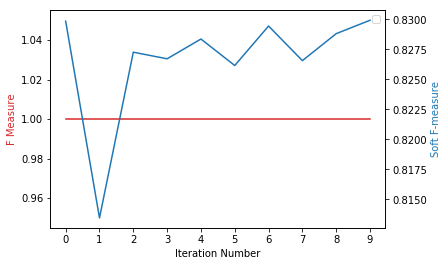

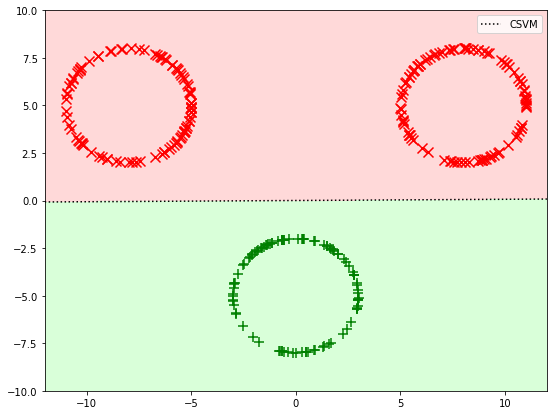

In [6]:
# The above method is self-tuning. If provided with data that is not
# severely imbalanced and nicely linearly separable, it keeps offering
# a perfect classifier. The advantage of the above method is for data
# with moderate to severe imbalance where naive classifiers fail.
def genBalancedStackedCirclesData( d, n, r, b ):
    tmp1 = gsd.genSphericalData( d, n, [0, -5], r )
    XPos = np.vstack( (tmp1) )
    yPos = np.ones( (XPos.shape[0],) )
    
    tmp1 = gsd.genSphericalData( d, n, [-8, 5], r )
    tmp2 = gsd.genSphericalData( d, n, [8, 5], r )
    XNeg = np.vstack( (tmp1, tmp2) )
    yNeg = -np.ones( (XNeg.shape[0],) )
    
    return (XPos, yPos, XNeg, yNeg)

d = 2 
n = 100
b = 30
r = 3

(XPos, yPos, XNeg, yNeg) = genBalancedStackedCirclesData( d, n, r, b )

Xtrn = np.vstack( (XPos, XNeg) )
ytrn = np.concatenate( (yPos, yNeg) )
randPerm = np.random.permutation( Xtrn.shape[0] )
Xtrn = Xtrn[randPerm,:]
ytrn = ytrn[randPerm]

niter = 10
(clf, perf, softPerf) = optimizeFMeasure( Xtrn, ytrn, niter )

plt.figure()
ax = plt.gca()
ax.set_xlabel( "Iteration Number" )
ax.xaxis.set_major_locator( MaxNLocator( integer = True ) )
ax.set_ylabel( "F Measure", color = "tab:red" )
ax.plot( np.arange( niter ), perf, color = "tab:red" )
ax2 = ax.twinx()
ax2.plot( np.arange( niter ), softPerf, color = "tab:blue" )
ax2.set_ylabel( "Soft F-measure", color = "tab:blue" )
plt.legend()

fig3 = pd.getFigure( 9, 7 )
pd.shade2D( linearCSVMClassifier, fig2, mode = 'batch', xlim = 12, ylim = 10 )
pd.plot2D( XPos, fig3, color = 'g', marker = '+' )
pd.plot2D( XNeg, fig3, color = 'r', marker = 'x' )
pd.plotLine( clf.coef_.T, clf.intercept_, fig3, linestyle = ':', xlimL = -12, xlimR = 12, label = "CSVM" )